## Financial Fraud Detection Agentic Ai


* This code is a part of a machine learning pipeline that processes a dataset, performs exploratory data analysis (EDA), trains a decision tree classifier, makes predictions, evaluates the model, and suggests improvements if necessary.

* It uses the LangGraph library to define a state graph for the pipeline, with each step represented as a node in the graph.
* The pipeline starts by ingesting a dataset, followed by EDA, training the model, making predictions, evaluating the model's performance, and finally checking if retraining is needed based on the accuracy of the model.
* The final state of the pipeline is returned after invoking the pipeline with the initial state.

In [15]:
from langgraph.graph import StateGraph, START
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [16]:
import numpy as np

In [17]:
from typing import TypedDict, Optional
from langgraph.graph import StateGraph

class AgentState(TypedDict, total=False):
    filepath: str
    df: pd.DataFrame
    model: RandomForestClassifier
    X_test: pd.DataFrame
    y_test: pd.Series
    predictions: list
    report: dict
    retrain: bool
    loop_count: Optional[int]
    eda_done : bool


graph = StateGraph(AgentState)

In [18]:
#Initial State
initial_state = {
    "filepath": "PS_20174392719_1491204439457_log.csv"  # Change this to your dataset path
}

### 1. Ingestion Agent

In [19]:
def ingest_agent(state: AgentState):
    df = pd.read_csv(state["filepath"])
    state["df"] = df
    return state

### 2. EDA Agent

In [ ]:
def eda_agent(state: AgentState):
    df = state["df"]
    #plt.figure(figsize=(6,6))
    #type_counts = df['type'].value_counts()
    #plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%')
    #plt.title("Transaction Type Distribution")
    #plt.show()

    plt.figure(figsize=(6,6))
    is_fraud_counts = df['isFraud'].value_counts()
    labels = [f"{'Non-Fraud' if label == 0 else 'Fraud'} ({count})" for label, count in is_fraud_counts.items()]
    plt.pie(is_fraud_counts, labels=labels, autopct='%1.1f%%')
    plt.title("Fraudulent Transaction Distribution")
    plt.show()

    state["eda_done"] = True
    return state

### 3. Model trainer Agent

In [21]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

In [ ]:
def train_agent(state: AgentState):
    df = state["df"].copy()
    df["isFraud"] = df["isFraud"].astype(int)
    X = df[["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]]
    y = df["isFraud"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Define a smaller parameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    # Create a Decision Tree Classifier
    model = RandomForestClassifier( class_weight='balanced', random_state=42, n_estimators=50, max_features='sqrt', n_jobs=-1)

    # Use RandomizedSearchCV to find the best hyperparameters
    random_search = RandomizedSearchCV(model, param_grid, cv=2, scoring='f1', n_iter=3, random_state = 42)  # Reduced cv and n_iter
    random_search.fit(X_train, y_train)

    # Get the best estimator
    best_clf = random_search.best_estimator_

    state.update({
        "model": best_clf,
        "X_test": X_test,
        "y_test": y_test,
        "trained": True
    })

    print("Model trained successfully.")
    return state

### 4. Predictor Agent

In [23]:
def predict_agent(state: AgentState):
    clf = state["model"]
    X_test = state["X_test"]

    # Step 1: Get fraud probabilities (class 1)
    y_probs = clf.predict_proba(X_test)[:, 1]

    # Step 2: Apply custom threshold (e.g., 0.3)
    predictions = (y_probs > 0.3).astype(int)

    state["predictions"] = predictions
    print("Predictions made successfully.")
    return state

### 5. Evaluator Agent

In [24]:
def evaluation_agent(state: AgentState):
    y_true = state["y_test"]
    y_pred = state["predictions"]

    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=["Actual non-fraud", "Actual fraud"], columns=["Predicted non-fraud", "Predicted fraud"])

    report = classification_report(y_true, y_pred, output_dict=True)

    # Calculate additional metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    plt.savefig("confusion_matrix.png")

    print("Accuracy:", report["accuracy"])
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("AUC:", auc)

    state["report"] = report
    state["precision"] = precision
    state["recall"] = recall
    state["f1"] = f1
    state["auc"] = auc
    return state

### 6. Improver Agent

In [25]:
def improver_agent(state: AgentState):
    acc = state["report"]["accuracy"]
    loop_count = state.get("loop_count", 0)
    
    if acc < 0.9999 and loop_count < 2:
        print("Retraining suggested due to accuracy below 99.99%")
        state["retrain"] = True
        state["loop_count"] = loop_count + 1
    else:
        print("Model training complete - either accuracy is satisfactory or max retraining reached")
        state["retrain"] = False
    return state

In [26]:
def exit_agent(state: AgentState):
    print("Pipeline complete")
    return state

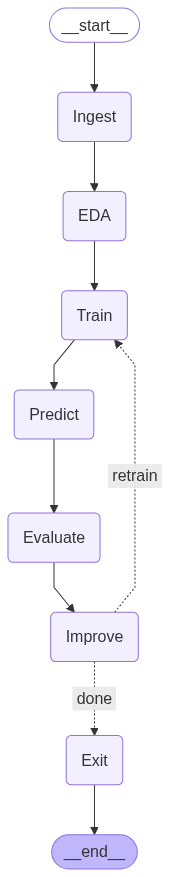

In [27]:
graph = StateGraph(AgentState)
graph.add_node("Ingest", ingest_agent)
graph.add_node("EDA", eda_agent)
graph.add_node("Train", train_agent)
graph.add_node("Predict", predict_agent)
graph.add_node("Evaluate", evaluation_agent)
graph.add_node("Improve", improver_agent)
graph.add_node("Exit", exit_agent)


#graph.add_edge(START, "Ingest")
graph.add_edge("Ingest", "EDA")
graph.add_edge("EDA", "Train")
graph.add_edge("Train", "Predict")
graph.add_edge("Predict", "Evaluate")
graph.add_edge("Evaluate", "Improve")

def should_loop(state: AgentState) -> str:
    if state.get("retrain", False):
        return "retrain"
    return "Exit"  # Changed from "done" to "exit"


graph.add_conditional_edges(
    "Improve",
    should_loop,
    {
        "retrain": "Train",
        "done": "Exit",  # Corrected this line
    },
)

graph.set_entry_point("Ingest")
graph.set_finish_point("Exit")
pipeline = graph.compile()

# Visualize the graph
#try block is initiated to attempt to execute some code that might raise an exception.
#Inside the try block, the display function is called with an Image object as its argument.
#The Image object is created with a PNG image generated by the draw_mermaid_png method of the get_graph method of graph.

from IPython.display import Image, display
try:
    display(Image(pipeline.get_graph().draw_mermaid_png()))
except Exception:
    pass

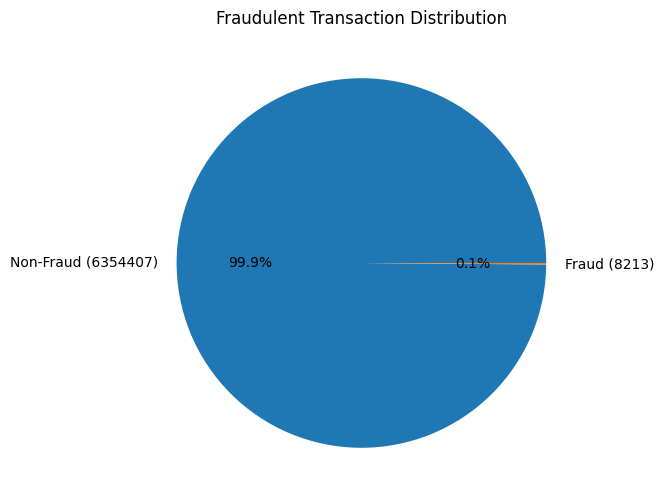

<Figure size 1000x1000 with 0 Axes>

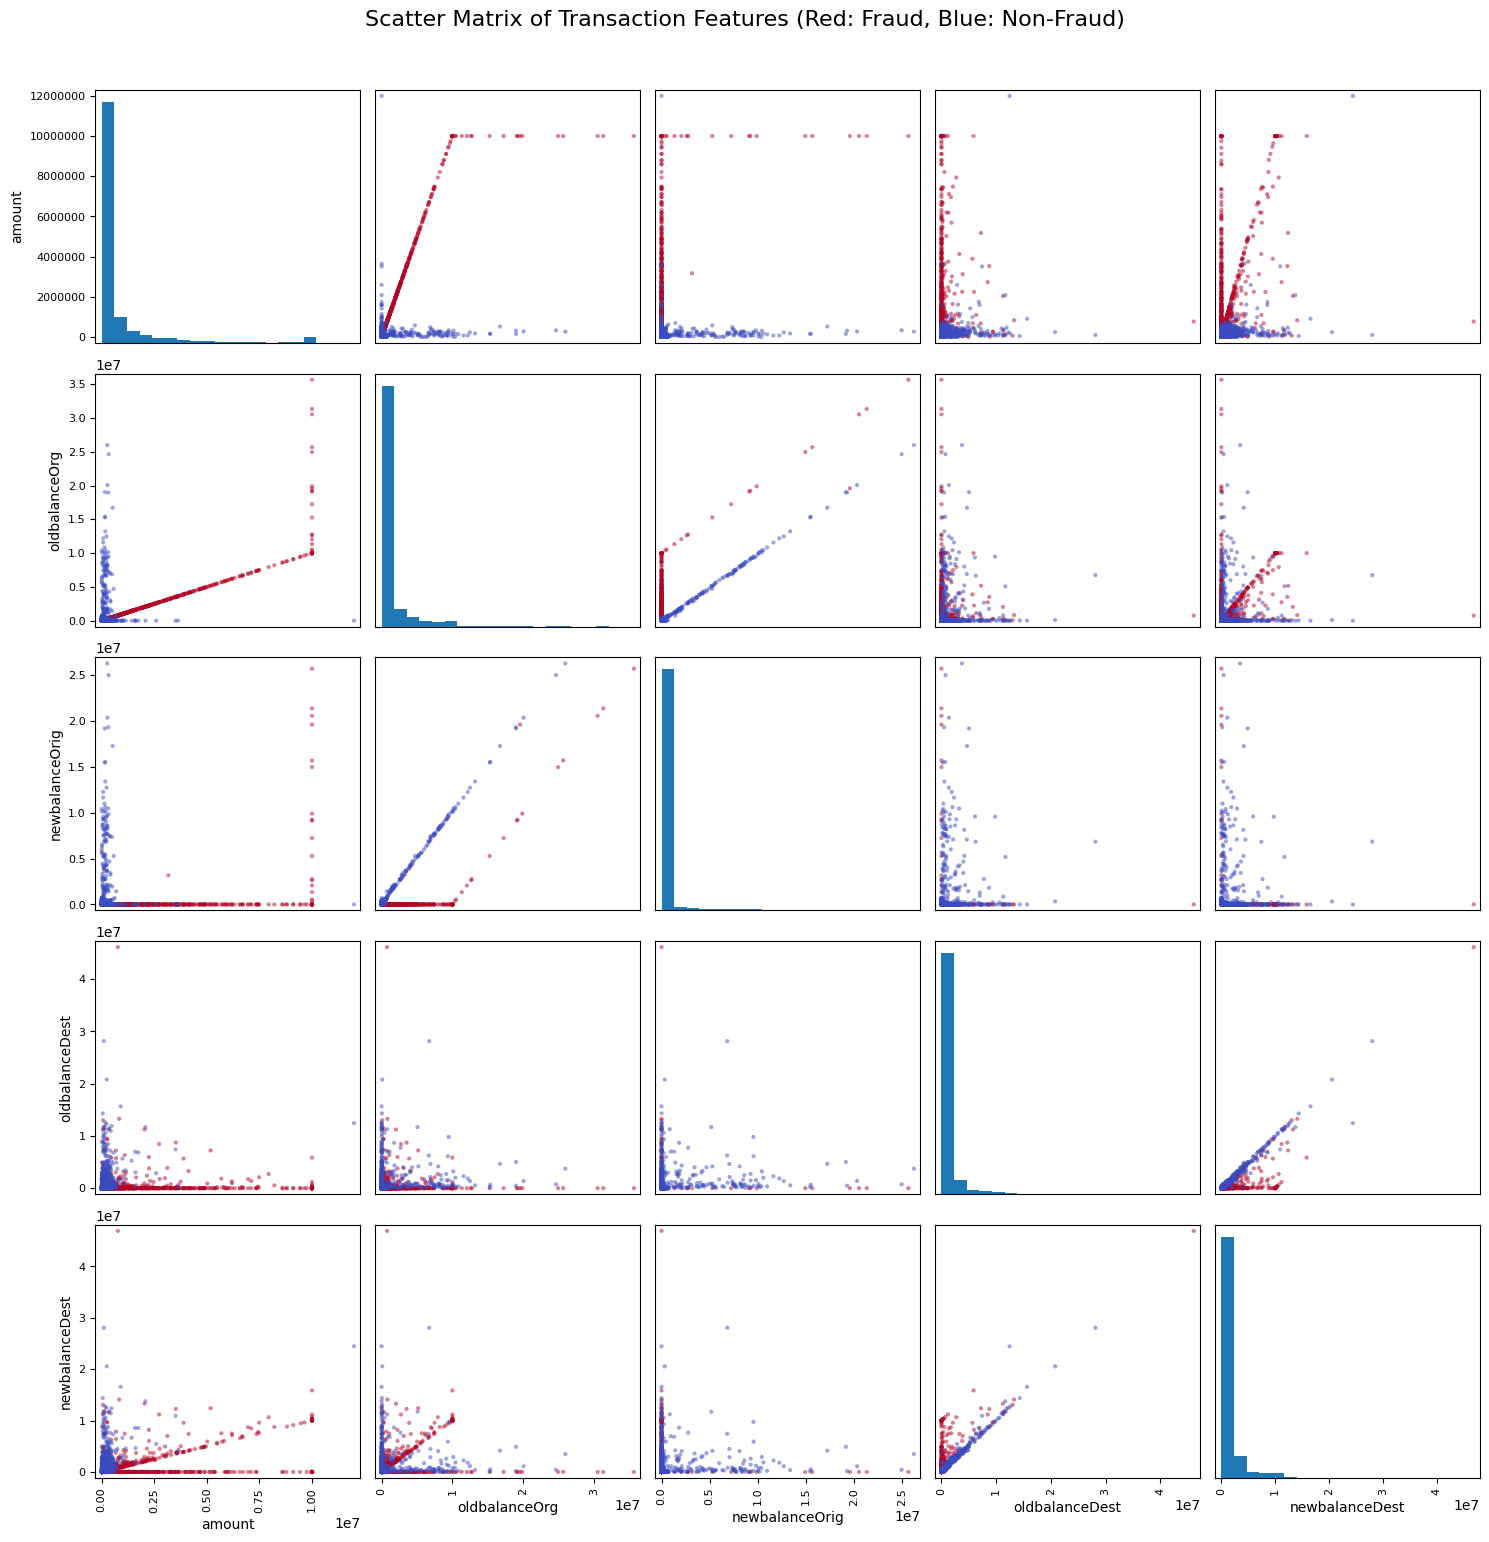

KeyboardInterrupt: 

In [28]:
final_state = pipeline.invoke(initial_state)